In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import rotate
from torchsummary import summary
import matplotlib.pyplot as plt

In [6]:
 class OCNN(nn.Module):
    def __init__(self):
        super(OCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(32 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 1)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 12 * 12)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x 

In [4]:
class RotationDataset(ImageFolder):
    def __init__(self, root, transform=None):
        super(RotationDataset, self).__init__(root, transform)
        
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)
        
        # Apply random rotation augmentation
        angle = torch.randint(0, 360, size=(1,))
        rotated_img = rotate(img, angle.item())
        
        if self.transform is not None:
            img = self.transform(img)
            rotated_img = self.transform(rotated_img)
        
        return img, rotated_img,angle


In [7]:


torch.manual_seed(0)
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])
train_dataset = RotationDataset('JP_Data1', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

network = OCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [8]:
summary(network,(1,61,61))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 57, 57]             416
         MaxPool2d-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 32, 24, 24]          12,832
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Linear-5                  [-1, 120]         553,080
            Linear-6                    [-1, 1]             121
Total params: 566,449
Trainable params: 566,449
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.67
Params size (MB): 2.16
Estimated Total Size (MB): 2.84
----------------------------------------------------------------


In [9]:

num_epochs = 1000

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for inputs, rotated_inputs,angle in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = network(rotated_inputs).reshape(inputs.size(0))
        # Compute loss using rotation-based pretext task
        rotation_labels = angle.squeeze()/ 360
        loss = criterion(outputs, rotation_labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.8f}")

print("Training finished!")

Epoch [1/1000] Loss: 39.20775265
Epoch [2/1000] Loss: 44.37364268
Epoch [3/1000] Loss: 42.81937498
Epoch [4/1000] Loss: 44.69769210
Epoch [5/1000] Loss: 39.78494734
Epoch [6/1000] Loss: 37.29756552
Epoch [7/1000] Loss: 42.45640028
Epoch [8/1000] Loss: 43.78690732
Epoch [9/1000] Loss: 39.83128262
Epoch [10/1000] Loss: 38.28010571
Epoch [11/1000] Loss: 36.97672260
Epoch [12/1000] Loss: 44.20496839
Epoch [13/1000] Loss: 40.68913245
Epoch [14/1000] Loss: 36.16617996
Epoch [15/1000] Loss: 38.82056904
Epoch [16/1000] Loss: 43.45310986
Epoch [17/1000] Loss: 41.18214226
Epoch [18/1000] Loss: 39.22393668
Epoch [19/1000] Loss: 36.27162760
Epoch [20/1000] Loss: 36.25290048
Epoch [21/1000] Loss: 40.58522564
Epoch [22/1000] Loss: 41.66191900
Epoch [23/1000] Loss: 37.53294772
Epoch [24/1000] Loss: 40.95462695
Epoch [25/1000] Loss: 40.92759460
Epoch [26/1000] Loss: 43.86600190
Epoch [27/1000] Loss: 37.92090744
Epoch [28/1000] Loss: 39.84621108
Epoch [29/1000] Loss: 37.97719729
Epoch [30/1000] Loss: 4

KeyboardInterrupt: 

In [224]:
dataiter=iter(train_dataloader)
img,rimg,angle=next(dataiter)
rotation_labels = angle.squeeze()/ 360
rotation_labels=rotation_labels.float().reshape(img.size(0),1)

In [225]:
outputs=network(rimg)

In [227]:
rotation_labels

tensor([[0.5139],
        [0.6667],
        [0.8583],
        [0.2389],
        [0.7278],
        [0.7861],
        [0.1444],
        [0.4111],
        [0.5722],
        [0.3944],
        [0.0111],
        [0.9417],
        [0.5417],
        [0.3000],
        [0.8667],
        [0.6389],
        [0.5944],
        [0.8056],
        [0.2000],
        [0.7194],
        [0.0389],
        [0.7222],
        [0.3306],
        [0.7083],
        [0.9389],
        [0.7583],
        [0.7361],
        [0.5639],
        [0.2944],
        [0.0889],
        [0.5361],
        [0.5806]])

In [231]:
criterion(outputs.reshape(32),rotation_labels.reshape(32))

tensor(59.6995, grad_fn=<DivBackward1>)

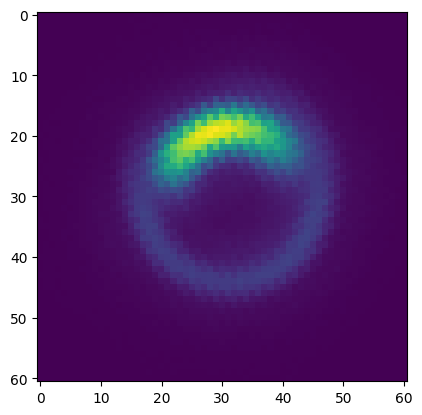

In [213]:
plt.imshow(rimg[2][0][:][:])